# 道路骨架提取

In [ ]:
import geopandas as gpd
import momepy
import libpysal
from shapely.ops import voronoi_diagram

# 准备建筑shp

In [58]:
import osmnx as ox
import geopandas as gpd

# Step 1：设置区域名称
place_name = "Tongji University, Shanghai, China"

# Step 2：下载该区域的建筑图层
buildings = ox.features_from_place(place_name, tags={'building': True})
print(len(buildings))
# Step 3：保留 polygon 类型（建筑轮廓）
buildings = buildings[buildings.geometry.type.isin(['Polygon', 'MultiPolygon'])]

# Step 4：保存为 Shapefile（可在 QGIS 中查看）
output_path = "buildings.shp"
buildings.to_file(output_path, encoding='utf-8')

print(f"建筑物图层已保存为：{output_path}")


125
建筑物图层已保存为：buildings.shp


C:\Users\Elena\AppData\Local\Temp\ipykernel_7736\699841399.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  buildings.to_file(output_path, encoding='utf-8')
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'name:en' to 'name_en'
  ogr_write(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'addr:city' to 'addr_city'
  ogr_write(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'addr:housenumber' to 'addr_house'
  ogr_write(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'addr:postcode' to 'addr_postc'
  ogr_write(
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normali

125


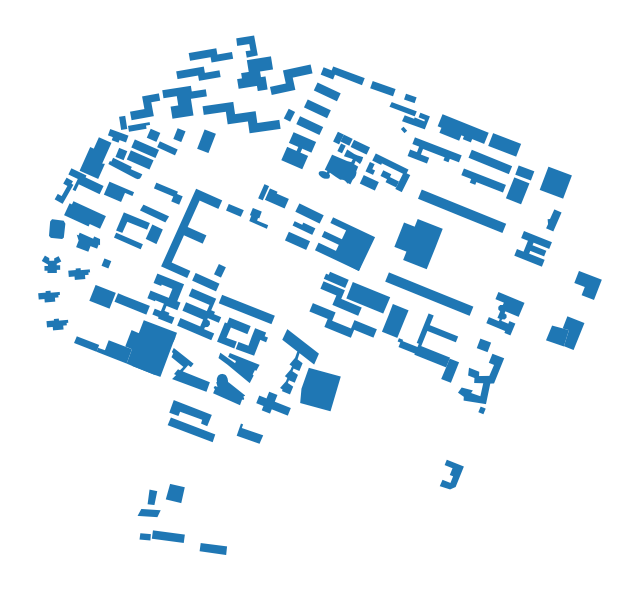

In [71]:
import momepy
import libpysal
from shapely.validation import make_valid
from shapely.geometry import Polygon, LineString
from shapely.errors import TopologicalError

# 建筑图层
buildings = gpd.read_file('buildings.shp').to_crs(epsg=32650)
print(len(buildings))
# 只保留 Polygon 或 MultiPolygon 类型

ax = buildings.plot(figsize=(8, 8))
ax.set_axis_off()



125
1


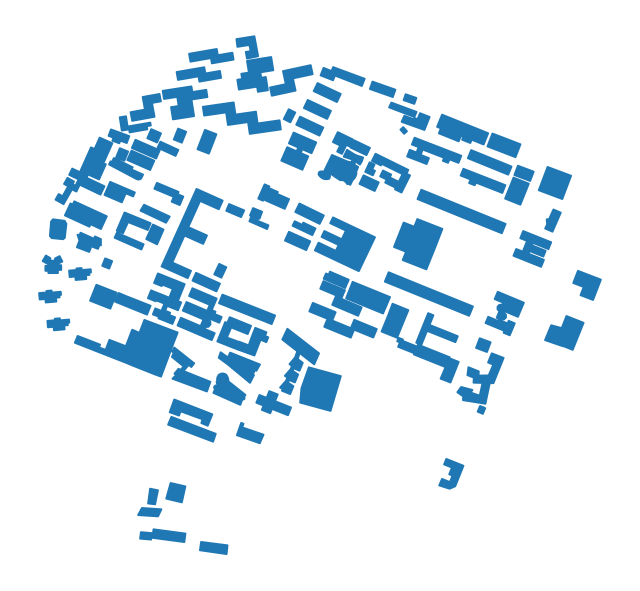

In [81]:
from shapely.ops import unary_union

buildings_buffered_5m = buildings.copy()
buildings_buffered_5m["geometry"] = buildings_buffered_5m.geometry.buffer(1)
# 第二步：在原来基础上再扩 2 米，控制建筑之间的最小距离
buildings_buffered_7m = buildings_buffered_5m.copy()
buildings_buffered_7m["geometry"] = buildings_buffered_7m.geometry.buffer(1)
print(len(buildings))
# 第三步：将所有相交图形合并为单个 Polygon 或 MultiPolygon
merged_geometry = unary_union(buildings_buffered_7m.geometry)
merged_gdf = gpd.GeoDataFrame(geometry=[merged_geometry], crs=buildings.crs)

ax = merged_gdf.plot(figsize=(8, 8))
ax.set_axis_off()
print(len(merged_gdf))

In [79]:

# 检查无效几何
def close_linearring(geom):
    if isinstance(geom, LineString):
        coords = list(geom.coords)
        if coords[0] != coords[-1]:
            coords.append(coords[0])  # 手动添加闭合点
        try:
            return Polygon(coords)  # 用闭合坐标构造 Polygon
        except Exception as e:
            print("Failed to convert to polygon:", e)
            return None
    return geom

limit = momepy.buffered_limit(merged_gdf, buffer=100)
# 细胞形态
# merged_gdf["uid"] = range(len(merged_gdf))  # 添加唯一标识字段
tess = momepy.Tessellation(merged_gdf,unique_id="uid",limit=limit)
cells = tess.tessellation
cells.head()


Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


,uid,geometry
0,0,"POLYGON ((927635.28 3469908.37, 927635.305 346..."


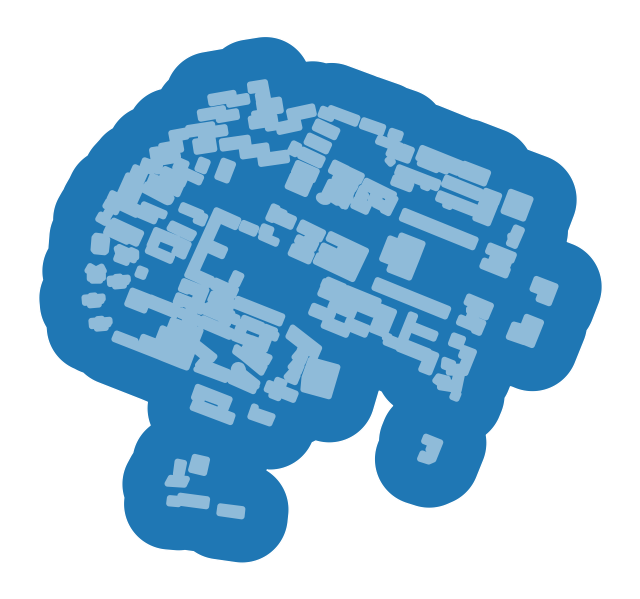

In [76]:
ax = cells.plot(edgecolor="white", figsize=(8, 8))
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()

In [59]:
# 提取Skeleton（街道骨架线）
skeleton = momepy.Skeleton(cells, edges=True)
edges = skeleton.skeleton

AttributeError: module 'momepy' has no attribute 'Skeleton'